In [29]:
#Python libraries
import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv

In [30]:
#check tensorflow version
print(tf.__version__)

2.10.0


In [31]:
#check GPU support
print(tf.config.list_physical_devices('GPU'))

[]


In [32]:
#initialize MetaTrader5 for history data
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [33]:
terminal_info=mt5.terminal_info()

In [34]:
#show file path
file_path=terminal_info.data_path+"\\MQL5\\Files\\"

In [35]:
#data path to save the model
data_path=argv[0]
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]

In [36]:
#set start and end dates for history data
from datetime import timedelta,datetime
end_date = datetime.now()
start_date = end_date - timedelta(days=120)

#print start and end dates
print("data start date=",start_date)
print("data end date=",end_date)

data start date= 2023-04-25 15:36:01.734231
data end date= 2023-08-23 15:36:01.734231


In [37]:
#get EURUSD rates (H1) from start_date to end_date
eurusd_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_H1, start_date, end_date)

In [38]:
#check
print(eurusd_rates)

[(1682427600, 1.10307, 1.1036 , 1.10197, 1.10207,  2269, 0, 0)
 (1682431200, 1.10207, 1.10238, 1.10096, 1.10169,  2555, 0, 0)
 (1682434800, 1.10169, 1.10294, 1.10141, 1.10173,  3669, 0, 0) ...
 (1692784800, 1.08614, 1.08715, 1.08115, 1.08182, 11465, 0, 0)
 (1692788400, 1.08181, 1.08304, 1.08152, 1.08192,  8383, 0, 0)
 (1692792000, 1.08193, 1.08205, 1.08084, 1.08099,  3592, 0, 0)]


In [39]:
#create dataframe
df = pd.DataFrame(eurusd_rates)

In [40]:
#show dataframe head
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1682427600,1.10307,1.10360,1.10197,1.10207,2269,0,0
1,1682431200,1.10207,1.10238,1.10096,1.10169,2555,0,0
2,1682434800,1.10169,1.10294,1.10141,1.10173,3669,0,0
3,1682438400,1.10173,1.10188,1.09944,1.09988,4508,0,0
4,1682442000,1.09987,1.10038,1.09752,1.09769,6522,0,0


In [41]:
#show dataframe tail
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume
2058,1692777600,1.08607,1.08634,1.08586,1.08625,1452,0,0
2059,1692781200,1.08624,1.08647,1.08522,1.08615,3463,0,0
2060,1692784800,1.08614,1.08715,1.08115,1.08182,11465,0,0
2061,1692788400,1.08181,1.08304,1.08152,1.08192,8383,0,0
2062,1692792000,1.08193,1.08205,1.08084,1.08099,3592,0,0


In [42]:
#show dataframe shape (the number of rows and columns in the data set)
df.shape

(2063, 8)

In [43]:
#prepare close prices only
data = df.filter(['close']).values

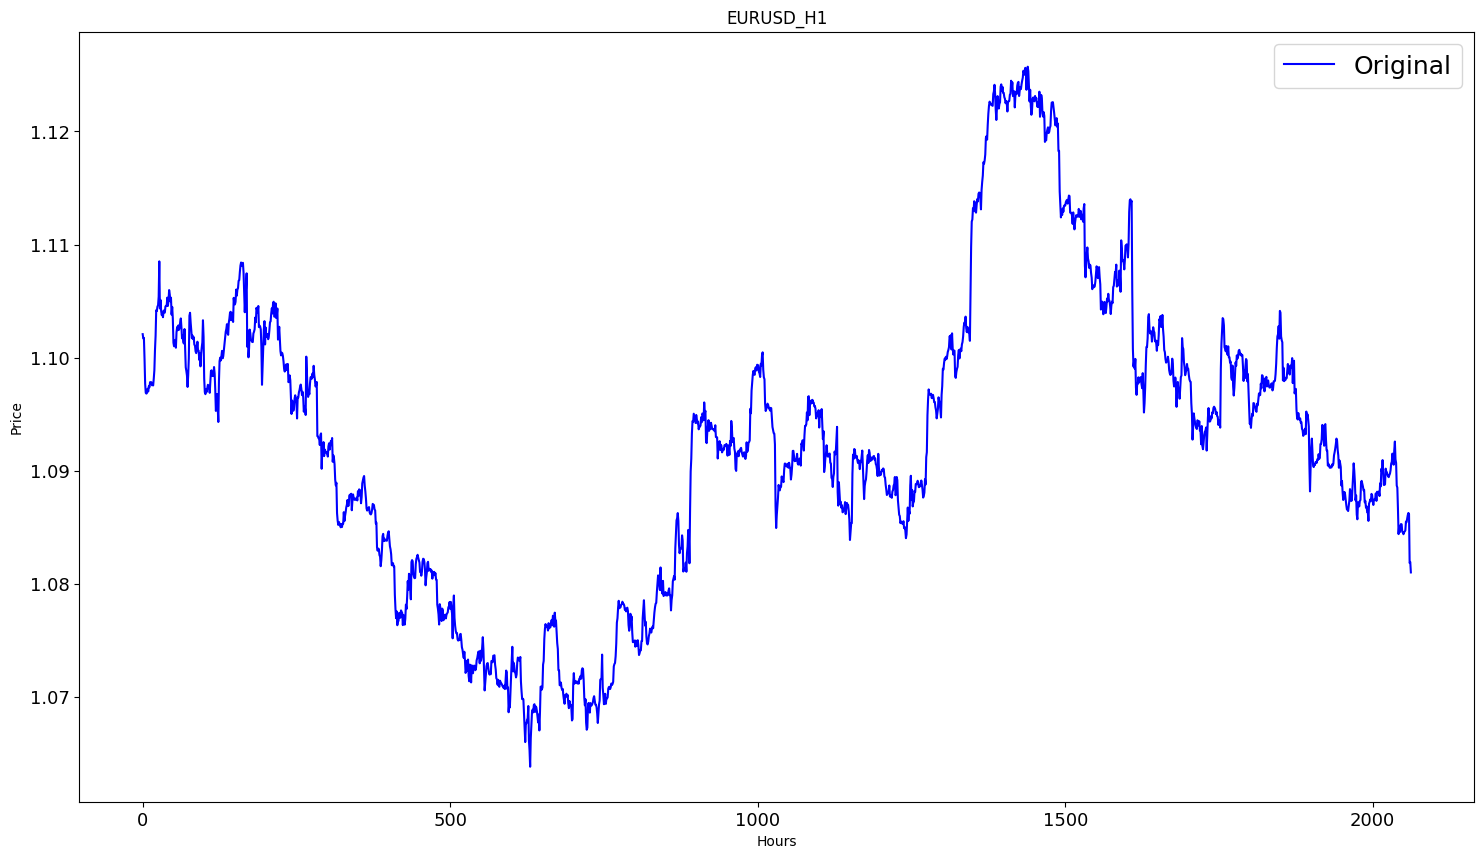

In [44]:
#show close prices
plt.figure(figsize = (18,10))
plt.plot(data,'b',label = 'Original')
plt.xlabel("Hours")
plt.xticks(fontsize=13)
plt.ylabel("Price")
plt.yticks(fontsize=13)
plt.title("EURUSD_H1")
plt.legend(fontsize=18)

In [45]:
#scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [46]:
#training size is 80% of the data
training_size = int(len(scaled_data)*0.80) 
print("training size:",training_size)

training size: 1650


In [47]:
#create train data and check size
train_data_initial = scaled_data[0:training_size,:]
print(len(train_data_initial))

1650


In [48]:
#create test data and check size
test_data_initial= scaled_data[training_size:,:1]
print(len(test_data_initial))

413


In [49]:
#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       #find the end of this pattern
       end_ix = i + n_steps
       #check if we are beyond the sequence
       if end_ix > len(sequence)-1:
          break
       #gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [50]:
#split into samples
time_step = 120
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)

In [51]:
#reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [52]:
#show shape of train data
x_train.shape

(1530, 120, 1)

In [53]:
#show shape of test data
x_test.shape

(293, 120, 1)

In [54]:
#import keras libraries for the model
import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Conv1D,MaxPooling1D,Dropout
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from keras.metrics import RootMeanSquaredError as rmse
from keras import optimizers

In [55]:
#define the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2,activation='relu',padding = 'same',input_shape=(120,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

In [56]:
#show model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 120, 256)          768       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 60, 256)          0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           142800    
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                      

In [57]:
#measure time
import time 
time_calc_start = time.time()

#fit model with 300 epochs
history=model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test),batch_size=32,verbose=2)

#calculate time
fit_time_seconds = time.time() - time_calc_start
print("fit time =",fit_time_seconds," seconds.")

Epoch 1/50
48/48 - 6s - loss: 0.0199 - root_mean_squared_error: 0.1411 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375 - 6s/epoch - 130ms/step
Epoch 2/50
48/48 - 4s - loss: 0.0036 - root_mean_squared_error: 0.0604 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414 - 4s/epoch - 92ms/step
Epoch 3/50
48/48 - 4s - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365 - 4s/epoch - 90ms/step
Epoch 4/50
48/48 - 4s - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333 - 4s/epoch - 92ms/step
Epoch 5/50
48/48 - 5s - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344 - 5s/epoch - 96ms/step
Epoch 6/50
48/48 - 4s - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 7.6183e-04 - val_root_mean_squared_error: 0.0276 - 4s/epoch - 90ms/step
Epoch 7/50
48/48 - 4s - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 6.2443

In [58]:
#show training history keys
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

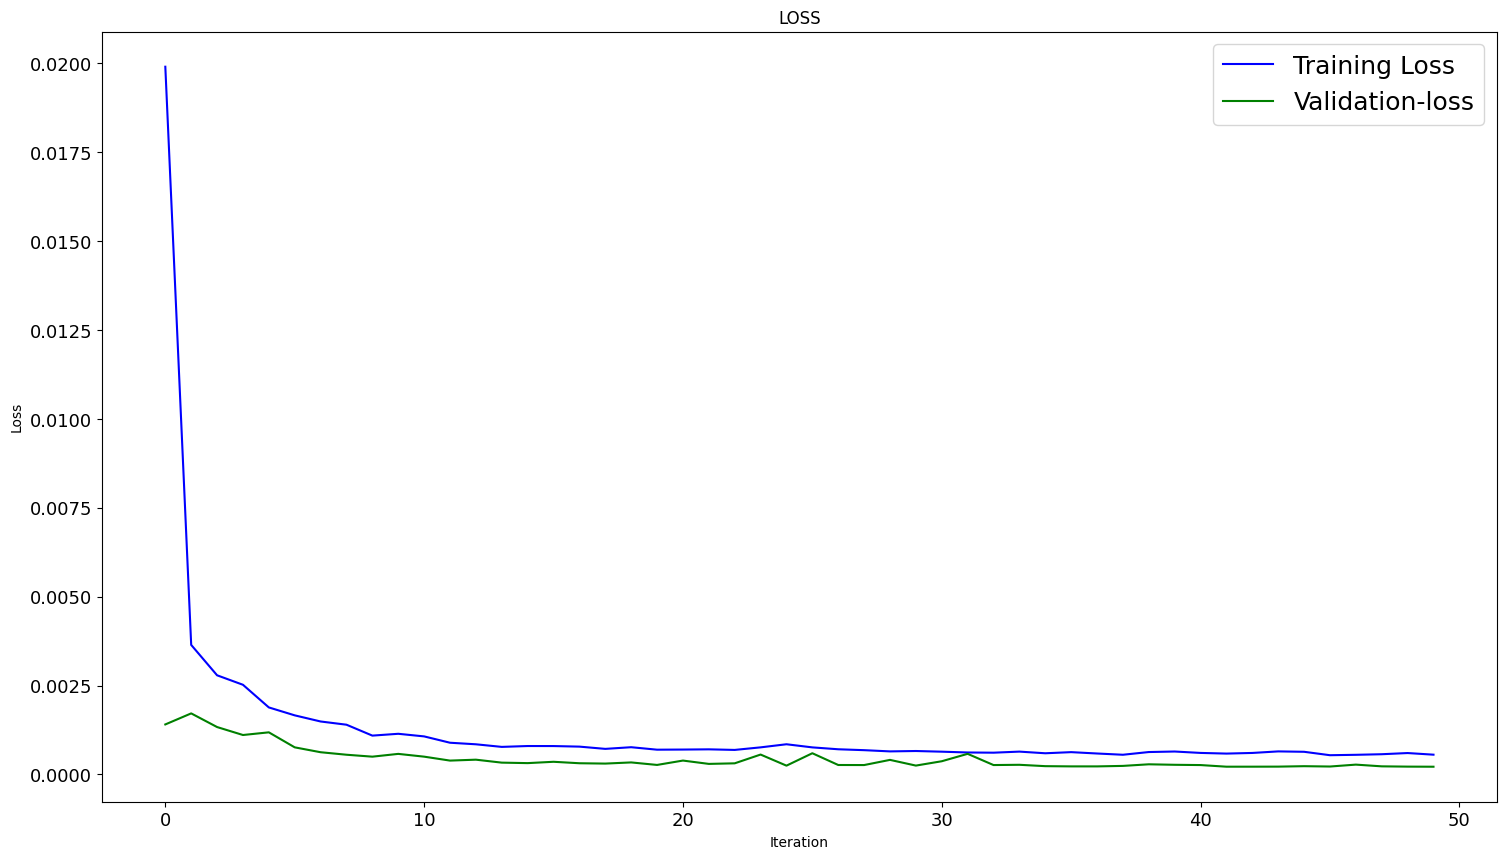

In [59]:
#show iteration-loss graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("LOSS")
plt.legend(fontsize=18)

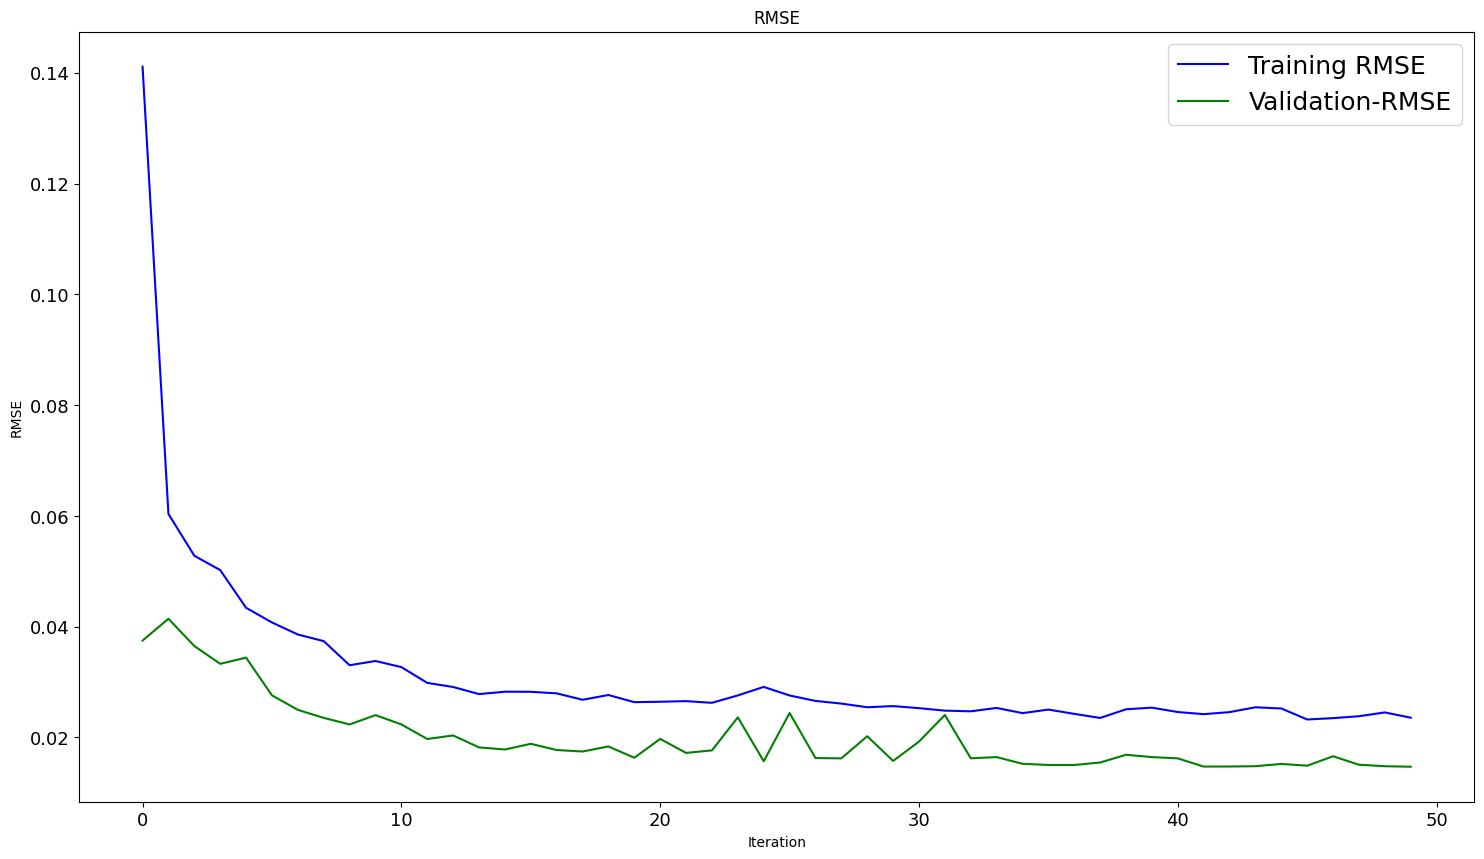

In [60]:
#show iteration-rmse graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['root_mean_squared_error'],label='Training RMSE',color='b')
plt.plot(history.history['val_root_mean_squared_error'],label='Validation-RMSE',color='g')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("RMSE")
plt.legend(fontsize=18)

In [61]:
#evaluate training data
model.evaluate(x_train,y_train, batch_size = 32)

48/48 [==============================] - 1s 21ms/step - loss: 3.0939e-04 - root_mean_squared_error: 0.0176


[0.0003093921986874193, 0.017589548602700233]

In [62]:
#evaluate testing data
model.evaluate(x_test,y_test, batch_size = 32)

10/10 [==============================] - 0s 21ms/step - loss: 2.1674e-04 - root_mean_squared_error: 0.0147


[0.00021673589071724564, 0.014721952378749847]

In [63]:
#prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1,1)

48/48 [==============================] - 1s 19ms/step


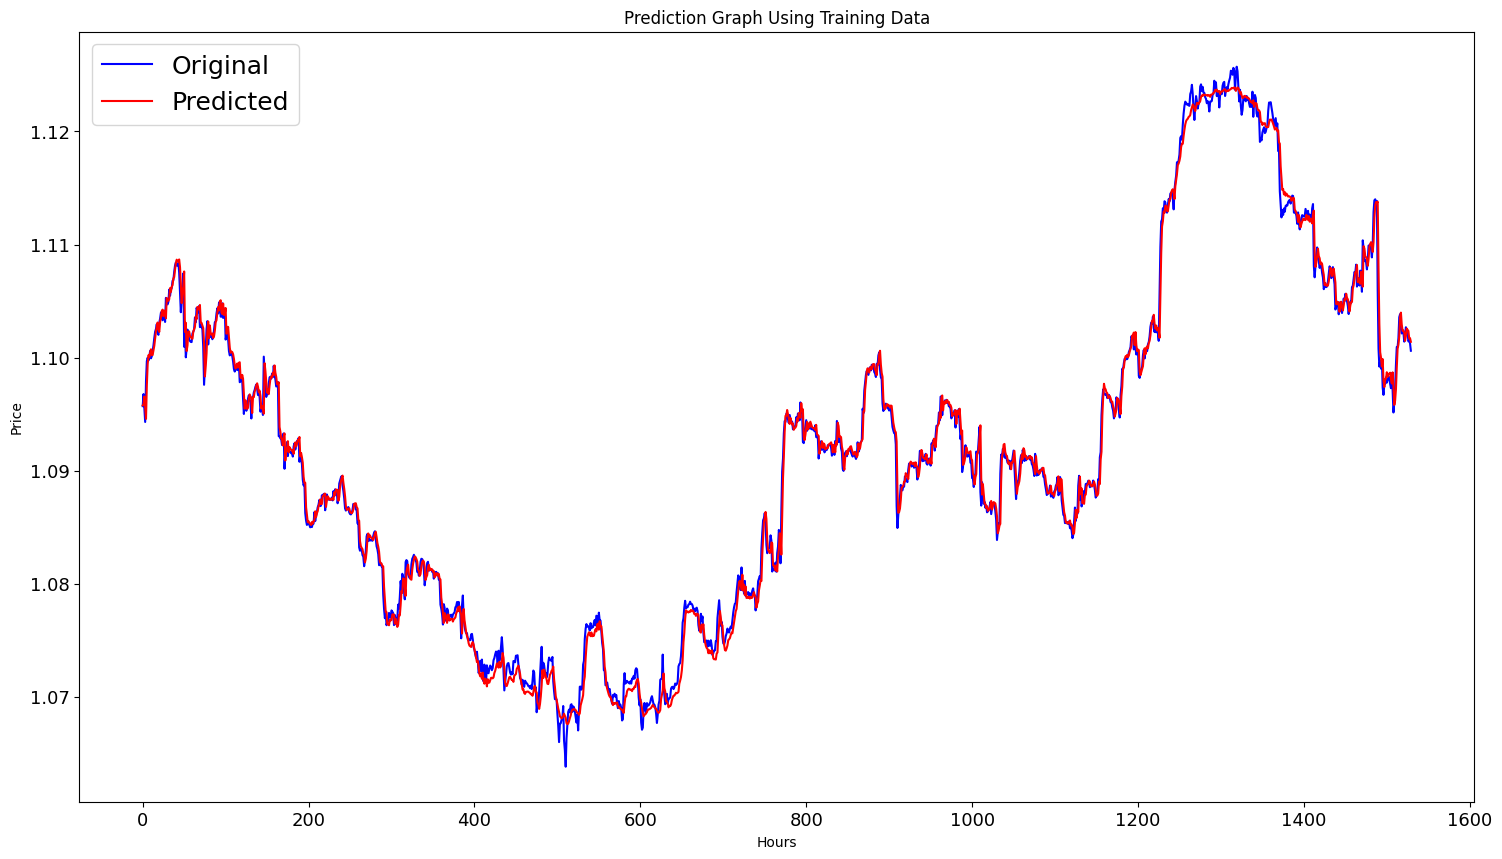

In [64]:
#show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=18)
plt.show()

In [65]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)

10/10 [==============================] - 0s 17ms/step


In [66]:
#calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score
#transform data to real values
value1=scaler.inverse_transform(plot_y_test)
value2=scaler.inverse_transform(test_predict)
#calc score
score = np.sqrt(metrics.mean_squared_error(value1,value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1,value2))
print("R2 score     :",metrics.r2_score(value1,value2))

RMSE         : 0.0009117270571920399
MSE          : 8.312462268160573e-07
R2 score     : 0.9667375138591522


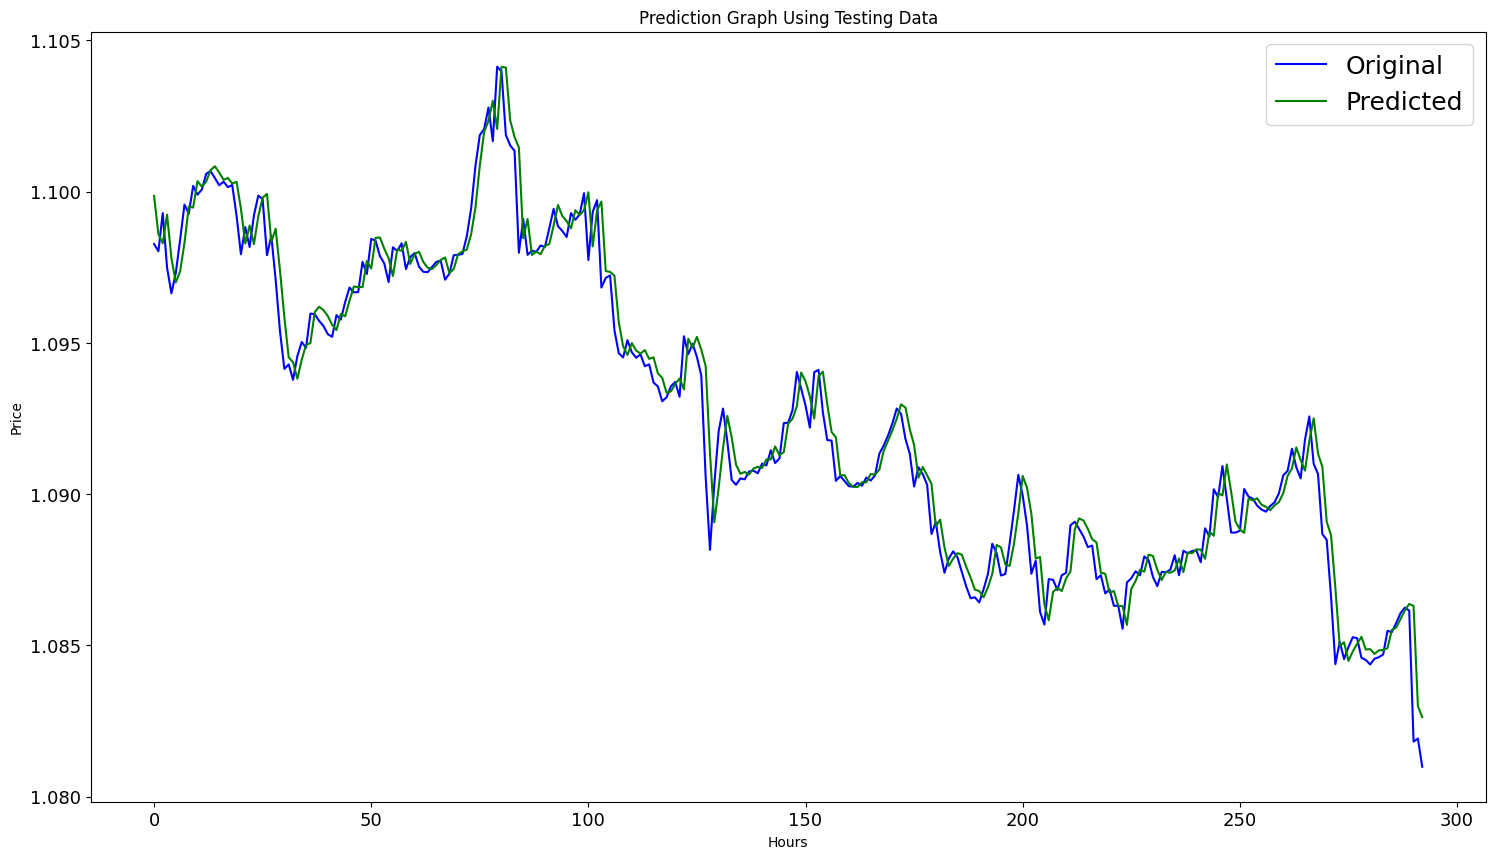

In [67]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=18)
plt.show()

In [68]:
# save model to ONNX
output_path = data_path+"model.eurusd.H1.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)

In [69]:
# finish
mt5.shutdown()

True